In [1]:
library("here")
library(devtools)
library(Seurat)

load_all('/home/jpm73279/Socrates')

here() starts at /home/jpm73279/Mendieta_et_al_comparative_single_cell

Loading required package: usethis

Attaching SeuratObject

Attaching sp

ℹ Loading Socrates
Loading required package: cicero

Loading required package: monocle

Loading required package: Matrix

Warning message:
"package 'Matrix' was built under R version 4.2.1"
Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Welcome to Biocon

In [2]:
# bed <- system.file("extdata", "test.tn5.bed.gz", package = "Socrates")
#ann <- system.file("extdata", "gencode.v19.annotation.gff3.gz", package = "Socrates")
#chr <- system.file("extdata", "hg19.txt", package = "Socrates")

reference_genome_path <- "/home/jpm73279/genome_downloads/Sbicolor.v5.1.prelim.annot/"
analysis_path <- "/scratch/jpm73279/comparative_single_cell/01.alignments_annotations/sorghum_bicolor/"

sb_leaf_rep_2 <- paste0(analysis_path, "Sorghum_leaf.sciATAC_rep2.unique.tn5.bed")

# set-up arguments

#ann <- "Zm-B73-REFERENCE-NAM-5.0_Zm00001eb.1.nuclear.gff3"
#chr <- "Zm-B73-REFERENCE-NAM-5.0.chrom.size"
#pre <- "Sb.Leaf_rep1"
#output <- as.character(args[5])

ann <- paste0(reference_genome_path,"Sbicolorv5.1.primaryTrs.gff3")
chr <- paste0(reference_genome_path,"Sorghum_bicolor_var_BTx623.chrom.size")
pre <- "Sb.Leaf_rep2.QC_v2"



#Load Object
sb_leaf_rep_2 <- loadBEDandGenomeData(sb_leaf_rep_2, ann, chr)
#zea_m.rep.peaks  <- paste0(pre, "macs2_temp", sep=".")

Running pre-check on input files and executable paths ...

BED file path = /scratch/jpm73279/comparative_single_cell/01.alignments_annotations/sorghum_bicolor/Sorghum_leaf.sciATAC_rep2.unique.tn5.bed ... ok

GFF file path = /home/jpm73279/genome_downloads/Sbicolor.v5.1.prelim.annot/Sbicolorv5.1.primaryTrs.gff3 ... ok

Chromosome sizes file path = /home/jpm73279/genome_downloads/Sbicolor.v5.1.prelim.annot/Sorghum_bicolor_var_BTx623.chrom.size ... ok

Macs2 is installed .... ok

 - loading data (this may take obj while for big BED files) ...

 - finished loading data



In [3]:
countRemoveOrganelle <- function(obj,
                                 org_scaffolds=NULL,
                                 remove_reads=FALSE){

    if (missing(org_scaffolds)) {

        message("... No Organelles Given, Returning All reads")

    } else {

        `%notin%` <- Negate(`%in%`)

        #Declare organelle scaffolds
        organelle = org_scaffolds

        #ID regions within the organelle
        org_group <- (obj$bed$V1 %in% organelle)

        if (sum(org_group) == 0) {
            message("No organeller reads identified ...")
            message("Are you sure the given names were correct?")
        }else{
            message("Identified ", sum(org_group), " organeller reads ...")
        }

        #Subset bed to only those
        organelle_sites <-  obj$bed[org_group, ]

        #Count the number of organelle reads present per barcode
        count_ID_number <- table(organelle_sites$V4)

        #Gather All Names to ID read names missing
        take_all_names <- unique(obj$bed$V4)

        #Grab all names with zero values
        cells_no_organelle_reads <- take_all_names[!(take_all_names %in% rownames(count_ID_number))]

        #Generate array using Table
        no_organelle_reads <- table(cells_no_organelle_reads)

        #Re-assing all values to 1
        no_organelle_reads[no_organelle_reads == 1] <- 0

        #Combine all
        zz <- c(no_organelle_reads, count_ID_number)

        if (remove_reads == TRUE){

            #Subsample bed so organelle reads do not interfere with ACR calls
            keep_bed_group <- c(obj$bed$V1 %notin% organelle)
            final_bed <- subset(obj$bed, keep_bed_group)
            obj$bed <- final_bed
            obj$PtMt <- zz

        } else {

            message("... Keeping organelle reads. This may affect ACR calling...")
            obj$PtMt <- zz

        }

        #Assign
        obj$PtMt <- zz
    }

    return(obj)
}

In [4]:
sb_leaf_rep_2.no_organelle <- countRemoveOrganelle(sb_leaf_rep_2, 
                                             org_scaffolds = c("Pt", "Mt"), 
                                             remove_reads = TRUE)

Identified 5114014 organeller reads ...



In [5]:
# call ACRs
sb_temp_dir <- paste0(analysis_path, "sb_peaks.3.tmp")
sb_leaf_rep_2.no_organelle <- callACRs(sb_leaf_rep_2.no_organelle, genomesize=1.8e8,
                shift= -50,
                extsize=100,
                fdr=0.05,
                tempdir=sb_temp_dir,
                verbose=T)

 - running MACS2 on bulk BED file ...

Warning message in dir.create(mac2temp):
"'/scratch/jpm73279/comparative_single_cell/01.alignments_annotations/sorghum_bicolor/sb_peaks.3.tmp' already exists"


In [6]:
sb_leaf_rep_2.meta <- buildMetaData(sb_leaf_rep_2.no_organelle,
                                     tss.window=2000,
                                     verbose=TRUE,
                                     organelle_scaffolds= c("Pt", "Mt"))

 - counting Tn5 sites per barcode ...

 - removing organelle scaffolds from annotation ...

 - counting Tn5 sites at TSSs per barcode ...

 - counting Tn5 sites within ACRs per barcode ...

 - finalizing meta data creation ...

   ~ returning metadata ...



In [7]:
sb_leaf_rep_2.meta$meta

,cellID,total,tss,acrs,ptmt
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
BC:Z:CAGATCAGTCAATGTCGGTAGAGACTA-Sorghum_leaf.sciATAC_rep2,BC:Z:CAGATCAGTCAATGTCGGTAGAGACTA-Sorghum_leaf.sciATAC_rep2,5902,2663,1986,106
BC:Z:CTTGTAAGTTCCTGTTTGTCCGCTCGG-Sorghum_leaf.sciATAC_rep2,BC:Z:CTTGTAAGTTCCTGTTTGTCCGCTCGG-Sorghum_leaf.sciATAC_rep2,4564,1266,698,126
BC:Z:CTTGTAATGTCAACTCGGGTAGCAGCT-Sorghum_leaf.sciATAC_rep2,BC:Z:CTTGTAATGTCAACTCGGGTAGCAGCT-Sorghum_leaf.sciATAC_rep2,90709,45202,45329,2163
BC:Z:GATCAGCTTGTATGTCGATGAGCTCGG-Sorghum_leaf.sciATAC_rep2,BC:Z:GATCAGCTTGTATGTCGATGAGCTCGG-Sorghum_leaf.sciATAC_rep2,12263,5542,4773,652
BC:Z:GGCTACCTTGTACTAAGGTCCGCCGAG-Sorghum_leaf.sciATAC_rep2,BC:Z:GGCTACCTTGTACTAAGGTCCGCCGAG-Sorghum_leaf.sciATAC_rep2,37698,10986,5641,2306
BC:Z:CTTGTACTTGTATGTCGCAAAAGCGCA-Sorghum_leaf.sciATAC_rep2,BC:Z:CTTGTACTTGTATGTCGCAAAAGCGCA-Sorghum_leaf.sciATAC_rep2,2645,536,143,236
BC:Z:CTTGTAAGTCAAGTCCTGTGGCCTCGG-Sorghum_leaf.sciATAC_rep2,BC:Z:CTTGTAAGTCAAGTCCTGTGGCCTCGG-Sorghum_leaf.sciATAC_rep2,22721,12519,15116,542
BC:Z:GATCAGCTTGTACCGAGGAGTGGTCGG-Sorghum_leaf.sciATAC_rep2,BC:Z:GATCAGCTTGTACCGAGGAGTGGTCGG-Sorghum_leaf.sciATAC_rep2,7957,1807,466,50
BC:Z:ACTTGACCGTCCATACGCGTACGACCG-Sorghum_leaf.sciATAC_rep2,BC:Z:ACTTGACCGTCCATACGCGTACGACCG-Sorghum_leaf.sciATAC_rep2,4473,1539,803,383



Attaching package: 'dplyr'


The following object is masked from 'package:MASS':

    select


The following object is masked from 'package:AnnotationDbi':

    select


The following object is masked from 'package:matrixStats':

    count


The following objects are masked from 'package:GenomicRanges':

    intersect, setdiff, union


The following object is masked from 'package:GenomeInfoDb':

    intersect


The following objects are masked from 'package:IRanges':

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from 'package:S4Vectors':

    first, intersect, rename, setdiff, setequal, union


The following object is masked from 'package:Biobase':

    combine


The following objects are masked from 'package:BiocGenerics':

    combine, intersect, setdiff, union


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




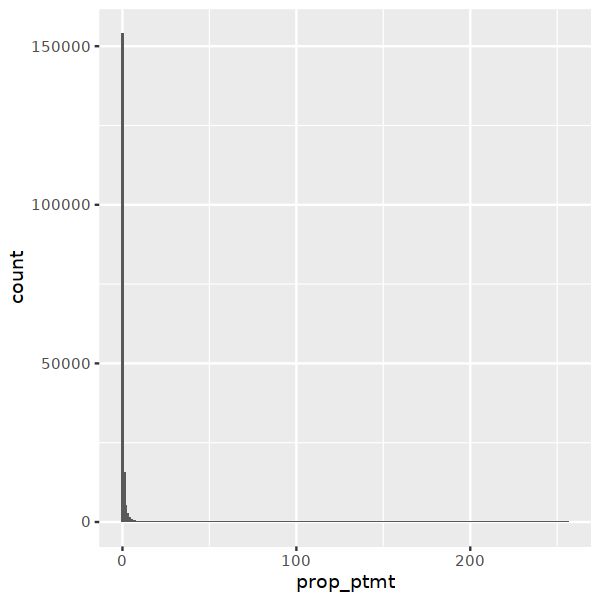

In [8]:
options(repr.plot.width=5, repr.plot.height=5)
library("dplyr")
sb_leaf_rep_2.meta$meta  %>% 
    dplyr::mutate(prop_ptmt = ptmt/total)  %>% 
    ggplot(., aes(prop_ptmt)) + geom_histogram(binwidth = 1)

Warning message:
"package 'repr' was built under R version 4.2.1"
Making Dotplot

... Filtering Cells based of Oragnelle Reads



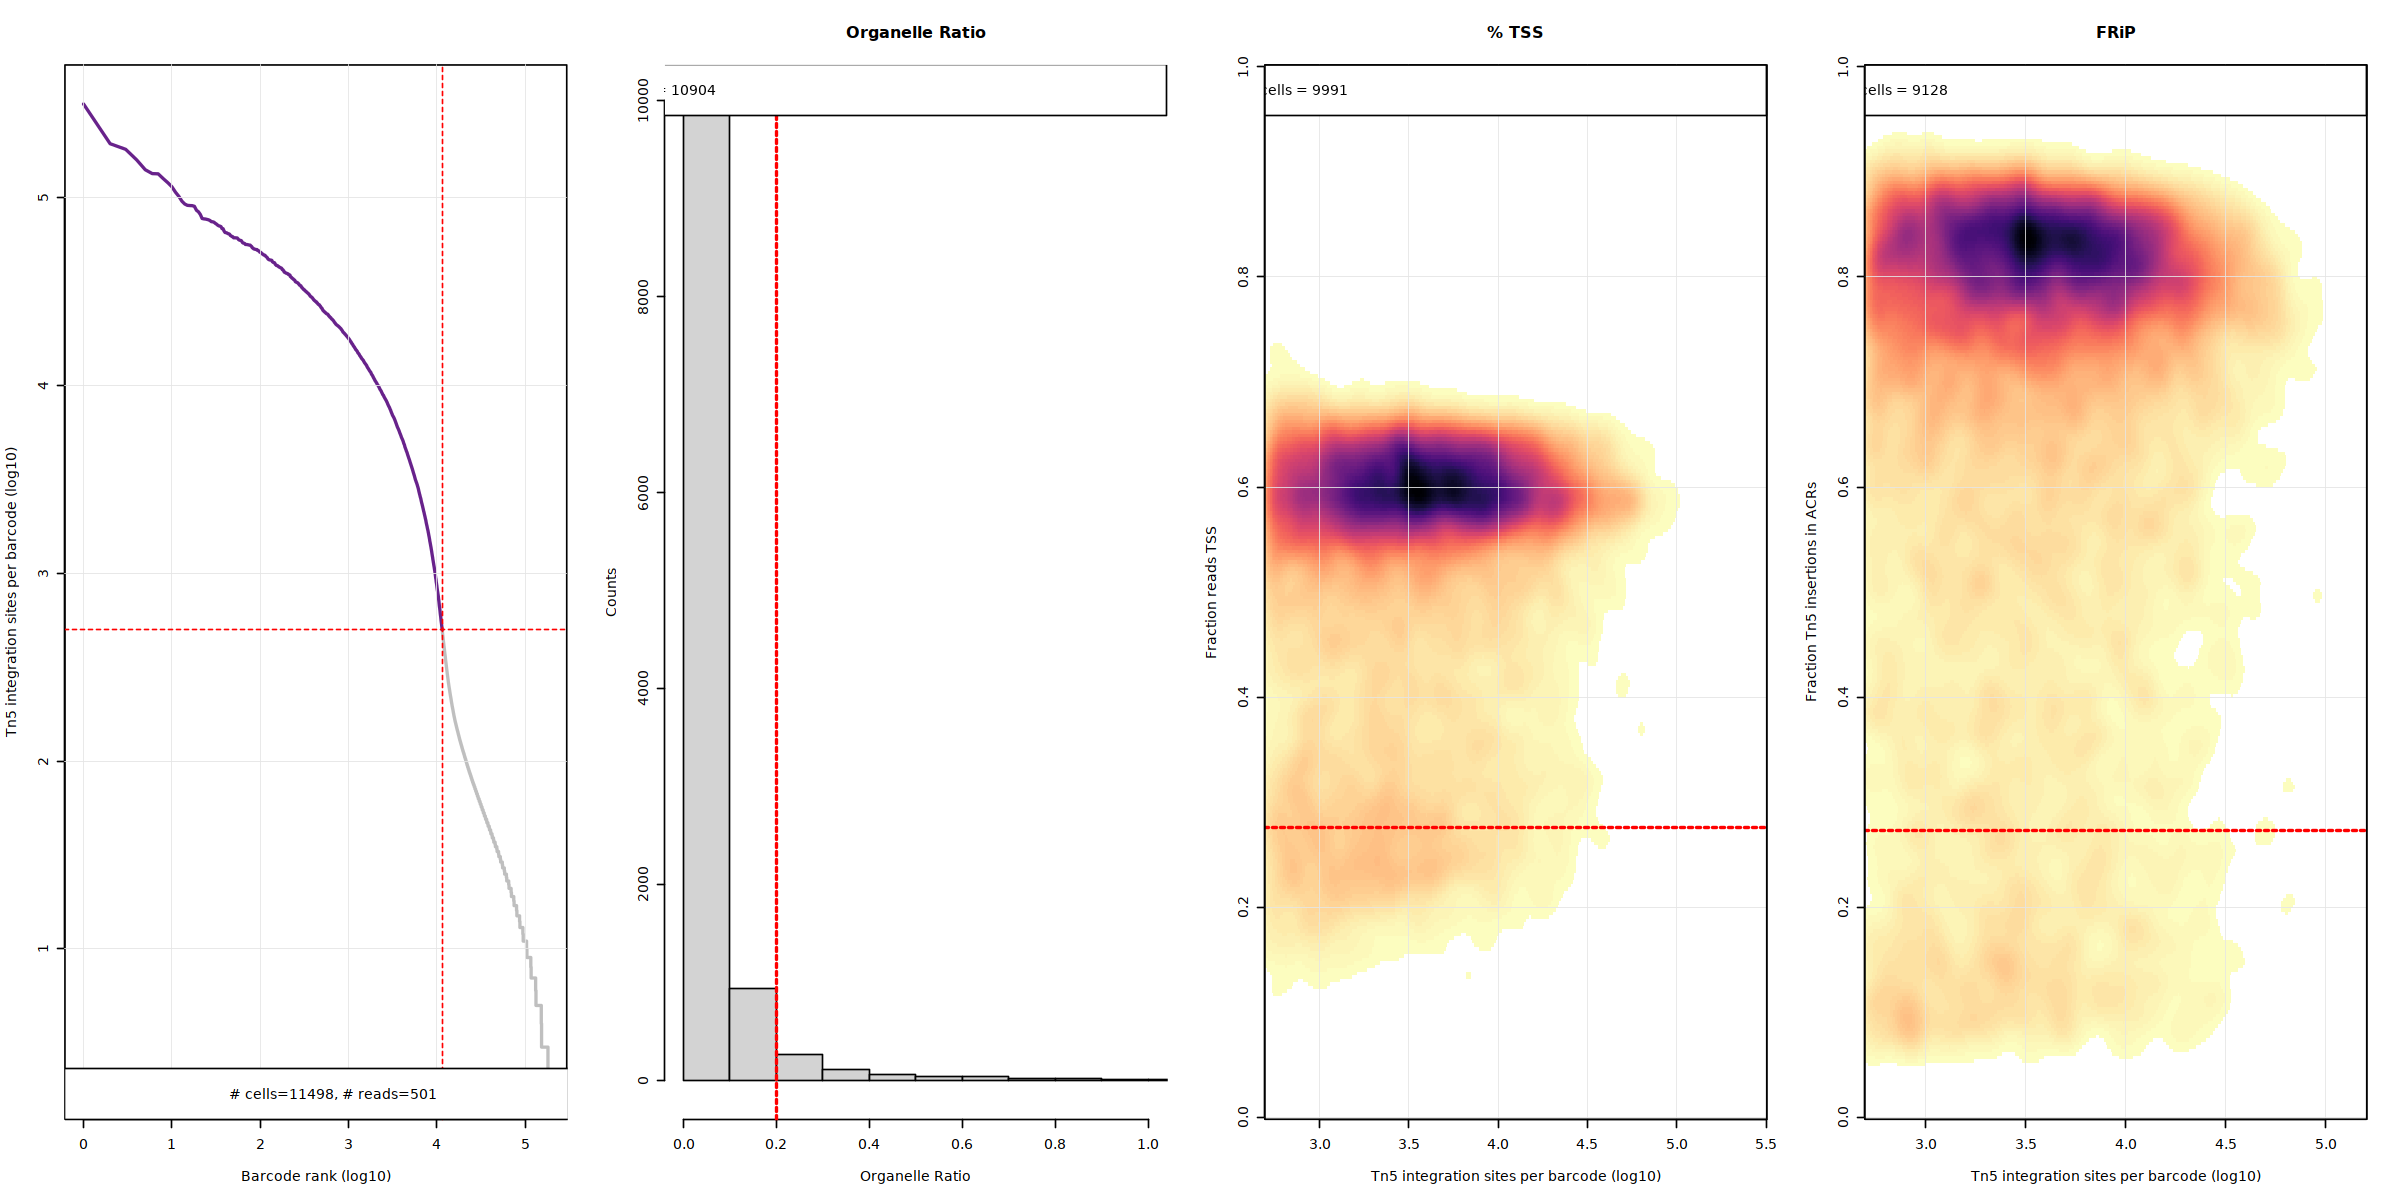

In [9]:
library(repr)

options(repr.plot.width=20, repr.plot.height=10)
sb_leaf_rep_2.meta <- findCells(sb_leaf_rep_2.meta,
                                        doplot=T,
                                        set.tn5.cutoff=500,
                                        max.cells=20000,
                                        min.tn5=500,
                                        filt.tss=TRUE,
                                        filt.frip=TRUE,
                                        #tss.z.thresh=3,
                                        tss.min.freq=.15,
                                        frip.min.freq=0.15,
                                        filt.org = TRUE,
                                        org.filter.thresh=0.2,
                                        prefix=NULL)


In [10]:
generateMatrix <- function(obj,
                           filtered=T,
                           windows=1000,
                           peaks=FALSE,
                           blacklist=NULL,
                           organelle_scaffolds = NULL,
                           verbose=T){
    

    # convert tn5 bed to Granges
    tn5.gr <- GRanges(seqnames=as.character(obj$bed$V1),
                      ranges=IRanges(start=as.numeric(obj$bed$V2),
                                     end=as.numeric(obj$bed$V3)),
                      strand=as.character(obj$bed$V5),
                      names=as.character(obj$bed$V4))
    
    
    # Remove Organell Scaffolds if given
    if(is.null(organelle_scaffolds) == FALSE) {
        
        tn5.gr <- dropSeqlevels(tn5.gr, organelle_scaffolds)

    } else {
        tn5.gr <- tn5.gr
    }

    
    # Read in baclist if given
    if(is.null(blacklist) == FALSE) {
        blacklist_r <- read.table(as.character(blacklist))

        blacklist.gr <- GRanges(seqnames=as.character(blacklist_r$V1),
                          ranges=IRanges(start=as.numeric(blacklist_r$V2),
                                         end=as.numeric(blacklist_r$V3)),
                          names=as.character(blacklist_r$V4))
    } else {
        blacklist.gr <- NULL
    }

    # use filtered barcodes?
    if(filtered){
        use <- obj$meta.v3
    }else{
        use <- obj$meta
    }


    # generate intervals
    if(!peaks){
        # build bins from specified tile length
        chr.seq.lengths <- as.numeric(obj$chr$V2)
        names(chr.seq.lengths) <- obj$chr$V1
        intervals <- tileGenome(chr.seq.lengths, tilewidth=windows, cut.last.tile.in.chrom=TRUE)

        #Remove if black list included
        #Remove procedure learned from: https://www.biostars.org/p/263214/
        if (is.null(blacklist.gr) == FALSE){

            intervals <- intervals[-queryHits(findOverlaps(intervals, blacklist.gr, type="any")),] 
            regions <- as.data.frame(intervals)
            regions <- paste(regions$seqnames, regions$start, regions$end, sep="_")


        }else{
            regions <- as.data.frame(intervals)
            regions <- paste(regions$seqnames, regions$start, regions$end, sep="_")
        }


    }else{

        # generate intervals from ACRs
        intervals <- GRanges(seqnames=as.character(obj$acr$V1),
                             ranges=IRanges(start=as.numeric(obj$acr$V2),
                                            end=as.numeric(obj$acr$V3)))

        if (is.null(blacklist.gr) == FALSE){
            intervals <- intervals[-queryHits(findOverlaps(intervals, blacklist.gr, type="any")),] 
            regions <- as.data.frame(intervals)
            regions <- paste(regions$seqnames, regions$start, regions$end, sep="_")
        }else{
            regions <- as.data.frame(intervals)
            regions <- paste(regions$seqnames, regions$start, regions$end, sep="_")
        }
    }


    # get intervals overlapping Tn5 sites by barcode
    hits <- as.data.frame(findOverlaps(tn5.gr, intervals))
    df <- data.frame(regions=regions[hits$subjectHits], barcodes=as.character(obj$bed$V4)[hits$queryHits])
    df <- df[!duplicated(df),]
    df$binary <- 1
    colnames(df) <- c("V1","V2","V3")
    
    
    #9/26/2022 include for sake of calculation of isCell 
    # make sure nSites is calculated
    #Integration Sites
    a <- df
    
    #Meta data to interset
    b <- use
    a$V1 <- factor(a$V1)
    a$V2 <- factor(a$V2)

    #Generate sparse matrix
    a <- Matrix::sparseMatrix(i=as.numeric(a$V1),
                              j=as.numeric(a$V2),
                              x=as.numeric(a$V3),
                              dimnames=list(levels(a$V1),levels(a$V2)))

    # align barcodes
    both <- intersect(rownames(b), colnames(a))
    a <- a[,both]
    b <- b[both,]

    # make sure nSites is calculated
    b$nSites   <- Matrix::colSums(a)
    b$log10nSites <- log10(b$nSites)

    # return
    obj$counts <- df
    obj$meta <- b 

    
    return(obj)
}

In [11]:
# generate sparse matrix
sb_leaf_rep_2.meta.filtered <- generateMatrix(sb_leaf_rep_2.meta,
                            filtered=FALSE,
                            windows=250,
                            peaks=FALSE,
                            organelle_scaffolds= c("Pt", "Mt"),
                            blacklist = "/home/jpm73279/genome_downloads/Sbicolor.v5.1.prelim.annot/sb_prelim.final_blacklist.bed",
                            verbose=T)

#rm(zea_m.Crown_root_1.obj.filtered, zea_m.Crown_root_1.obj.meta, zea_m.Crown_root_1.obj.no_organelle)

In [12]:
isCell <- function(obj, 
                   num.test=20000, 
                   num.tn5=NULL, 
                   num.ref=1000, 
                   background.cutoff=100,
                   min.pTSS=0.2, 
                   min.FRiP=0.2, 
                   min.pTSS.z= -2, 
                   min.FRiP.z= -2, 
                   verbose=F){
    
    # hidden functions
    .RowVar <- function(x) {
        spm <- t(x)
        stopifnot(methods::is(spm, "dgCMatrix"))
        ans <- sapply(base::seq.int(spm@Dim[2]), function(j) {
            if (spm@p[j + 1] == spm@p[j]) {
                return(0)
            }
            mean <- base::sum(spm@x[(spm@p[j] + 1):spm@p[j +
                                                             1]])/spm@Dim[1]
            sum((spm@x[(spm@p[j] + 1):spm@p[j + 1]] - mean)^2) +
                mean^2 * (spm@Dim[1] - (spm@p[j + 1] - spm@p[j]))
        })/(spm@Dim[1] - 1)
        names(ans) <- spm@Dimnames[[2]]
        ans
    }
    
    sparse_count_matrix <- obj$counts
    # make sure bins/cells are factors
    if(verbose){message(" - converting triplet format to sparseMatrix")}
    sparse_count_matrix$V1 <- factor(sparse_count_matrix$V1)
    sparse_count_matrix$V2 <- factor(sparse_count_matrix$V2)


    # convert to sparseMatrix format
    sparse_count_matrix <- Matrix::sparseMatrix(i=as.numeric(sparse_count_matrix$V1),
                              j=as.numeric(sparse_count_matrix$V2),
                              x=as.numeric(sparse_count_matrix$V3),
                              dimnames=list(levels(sparse_count_matrix$V1),levels(sparse_count_matrix$V2)))


    
    
    # select same cells 
    shared <- intersect(rownames(obj$meta), colnames(sparse_count_matrix))
    sparse_count_matrix <- sparse_count_matrix[,shared]
    obj$meta <- obj$meta[shared,]
    
    # generate stats
    obj$meta <- obj$meta[order(obj$meta$nSites, decreasing=T),]
    obj$meta$pTSS <- obj$meta$tss/obj$meta$total
    obj$meta$FRiP <- obj$meta$acrs/obj$meta$total
    obj$meta$pOrg <- obj$meta$ptmt/obj$meta$total
    
    # set initial thresholds
    if(verbose){message(" - setting filters")}
    obj$meta$tss_z <- (obj$meta$pTSS - mean(obj$meta$pTSS))/sd(obj$meta$pTSS)
    obj$meta$acr_z <- (obj$meta$FRiP - mean(obj$meta$FRiP))/sd(obj$meta$FRiP)
    obj$meta$sites_z <- (log10(obj$meta$nSites) - mean(log10(obj$meta$nSites)))/sd(log10(obj$meta$nSites))
    obj$meta$tss_z[is.na(obj$meta$tss_z)] <- -10
    obj$meta$acr_z[is.na(obj$meta$acr_z)] <- -10
    obj$meta$sites_z[is.na(obj$meta$sites_z)] <- -10 
    obj$meta$qc_check <- ifelse(obj$meta$tss_z < min.pTSS.z | obj$meta$pTSS < min.pTSS, 0, 
                              ifelse(obj$meta$acr_z < min.FRiP.z | obj$meta$FRiP < min.FRiP, 0, 1))
    
    # cells to test
    if(is.null(num.test)){
        test.set <- subset(obj$meta, obj$meta$total > num.tn5)
    }else{
        test.set <- head(obj$meta[order(obj$meta$total, decreasing=T),], n=num.test)
    }
    
    # select good cell reference
    if(verbose){message(" - parsing initial boundaries")}
    good.cells <- rownames(subset(obj$meta, obj$meta$qc_check==1))
    if(length(good.cells) > num.ref){
        good.cells <- head(good.cells, n=num.ref)
    }
    
    # select bad cell reference
    bad.cells <- rownames(subset(obj$meta, obj$meta$qc_check==0 & obj$meta$total < background.cutoff))
    
    # construct references
    gg <- sparse_count_matrix[,colnames(sparse_count_matrix) %in% good.cells]
    bb <- sparse_count_matrix[,colnames(sparse_count_matrix) %in% bad.cells]
    
    # select sites to use 
    sites <- Matrix::rowMeans(gg > 0)
    sites <- sites[order(sites, decreasing=T)]
    num.sites <- min(c(max(obj$meta$nSites), 250000))
    if(length(sites) < num.sites){
        num.sites <- length(sites)
    }
    
    # filter reference matrices
    gg <- gg[names(sites)[1:num.sites],]
    gg <- gg[,Matrix::colSums(gg) > 0]
    bb <- bb[rownames(gg),]
    bb <- bb[,Matrix::colSums(bb) > 0]
    shared <- intersect(rownames(gg), rownames(bb))
    gg <- gg[shared,]
    bb <- bb[shared,]
    gg <- gg[,Matrix::colSums(gg) > 0]
    bb <- bb[,Matrix::colSums(bb) > 0]
    
    # normalize references
    if(verbose){message(" - normalizing distributions and creating references")}
    sub.counts <- sparse_count_matrix[,c(colnames(gg), colnames(bb), rownames(test.set))]
    sub.counts <- sub.counts[rownames(gg),]
    all.res <- tfidf(list(counts=sub.counts), doL2=T)$residuals
    bb.norm <- all.res[,colnames(bb)]
    gg.norm <- all.res[,colnames(gg)]
    test.tfidf <- all.res[,rownames(test.set)]
    
    # pick sites
    if(verbose){message(" - performing feature selection (this step is a bottle-neck and may take a while to complete)")}
    res.ave <- Matrix::rowMeans(gg.norm)
    res.res <- .RowVar(gg.norm)
    resis <- res.res/res.ave
    #resis <- loess(res.res~res.ave)$residuals
    names(resis) <- rownames(gg.norm)
    resis <- resis[order(resis, decreasing=T)]
    top.sites <- names(resis)[1:100000]
    bb.norm <- bb.norm[top.sites,]
    gg.norm <- gg.norm[top.sites,]
    test.tfidf <- test.tfidf[top.sites,]
    
    # make bulk references, l2 norm
    bad.ref <- Matrix::rowMeans(bb.norm)
    good.ref <- Matrix::rowMeans(gg.norm)
    bad.ref <- Matrix(matrix(c(bad.ref / (sqrt(sum(bad.ref^2)))), ncol=1), sparse=T)
    good.ref <- Matrix(matrix(c(good.ref / (sqrt(sum(good.ref^2)))),ncol=1), sparse=T)
    ref <- cbind(bad.ref, good.ref)
    colnames(ref) <- c("background", "cellbulk")
    
    # prep test cells for comparisons 
    if(verbose){message(" - estimating correlations")}
    ref.cor <- corSparse(test.tfidf, ref)
    ref.cor <- as.data.frame(ref.cor)
    colnames(ref.cor) <- c("background", "cellbulk")
    rownames(ref.cor) <- colnames(test.tfidf)
    ref.cor$is_cell <- ifelse(ref.cor$cellbulk > ref.cor$background, 1, 0)
    
    # update meta data
    shared <- intersect(rownames(obj$meta), rownames(ref.cor))
    meta <- obj$meta[shared,]
    ref.cor <- ref.cor[shared,]
    updated.meta <- cbind(meta, ref.cor)
    nonrefs <- obj$meta[!rownames(obj$meta) %in% rownames(ref.cor),]
    nonrefs$background <- NA
    nonrefs$cellbulk <- NA
    nonrefs$is_cell <- NA
    updated <- rbind(updated.meta, nonrefs)
    
    # return
    obj$meta <- updated
    return(obj)
}

In [13]:
obj <- sb_leaf_rep_2.meta.filtered
                   num.test=20000
                   num.tn5=NULL
                   num.ref=1000 
                   background.cutoff=100
                   min.pTSS=0.2
                   min.FRiP=0.2 
                   min.pTSS.z= -2 
                   min.FRiP.z= -2 
                   verbose=F
    
    # hidden functions
    .RowVar <- function(x) {
        spm <- t(x)
        stopifnot(methods::is(spm, "dgCMatrix"))
        ans <- sapply(base::seq.int(spm@Dim[2]), function(j) {
            if (spm@p[j + 1] == spm@p[j]) {
                return(0)
            }
            mean <- base::sum(spm@x[(spm@p[j] + 1):spm@p[j +
                                                             1]])/spm@Dim[1]
            sum((spm@x[(spm@p[j] + 1):spm@p[j + 1]] - mean)^2) +
                mean^2 * (spm@Dim[1] - (spm@p[j + 1] - spm@p[j]))
        })/(spm@Dim[1] - 1)
        names(ans) <- spm@Dimnames[[2]]
        ans
    }
    
    sparse_count_matrix <- obj$counts
    # make sure bins/cells are factors
    if(verbose){message(" - converting triplet format to sparseMatrix")}
    sparse_count_matrix$V1 <- factor(sparse_count_matrix$V1)
    sparse_count_matrix$V2 <- factor(sparse_count_matrix$V2)

    message("Converting Sparse")
    # convert to sparseMatrix format
    sparse_count_matrix <- Matrix::sparseMatrix(i=as.numeric(sparse_count_matrix$V1),
                              j=as.numeric(sparse_count_matrix$V2),
                              x=as.numeric(sparse_count_matrix$V3),
                              dimnames=list(levels(sparse_count_matrix$V1),levels(sparse_count_matrix$V2)))


    message("Selecting Cells") 
    # select same cells 
    shared <- intersect(rownames(obj$meta), colnames(sparse_count_matrix))
    sparse_count_matrix <- sparse_count_matrix[,shared]
    obj$meta <- obj$meta[shared,]
    
    message("Taking Stats") 
    # generate stats
    obj$meta <- obj$meta[order(obj$meta$nSites, decreasing=T),]
    obj$meta$pTSS <- obj$meta$tss/obj$meta$total
    obj$meta$FRiP <- obj$meta$acrs/obj$meta$total
    obj$meta$pOrg <- obj$meta$ptmt/obj$meta$total
    
    message("Filtering") 
    # set initial thresholds
    if(verbose){message(" - setting filters")}
    obj$meta$tss_z <- (obj$meta$pTSS - mean(obj$meta$pTSS))/sd(obj$meta$pTSS)
    obj$meta$acr_z <- (obj$meta$FRiP - mean(obj$meta$FRiP))/sd(obj$meta$FRiP)
    obj$meta$sites_z <- (log10(obj$meta$nSites) - mean(log10(obj$meta$nSites)))/sd(log10(obj$meta$nSites))
    obj$meta$tss_z[is.na(obj$meta$tss_z)] <- -10
    obj$meta$acr_z[is.na(obj$meta$acr_z)] <- -10
    obj$meta$sites_z[is.na(obj$meta$sites_z)] <- -10 
    obj$meta$qc_check <- ifelse(obj$meta$tss_z < min.pTSS.z | obj$meta$pTSS < min.pTSS, 0, 
                              ifelse(obj$meta$acr_z < min.FRiP.z | obj$meta$FRiP < min.FRiP, 0, 1))
    
    # cells to test
    if(is.null(num.test)){
        test.set <- subset(obj$meta, obj$meta$total > num.tn5)
    }else{
        test.set <- head(obj$meta[order(obj$meta$total, decreasing=T),], n=num.test)
    }
    
    # select good cell reference
    if(verbose){message(" - parsing initial boundaries")}
    good.cells <- rownames(subset(obj$meta, obj$meta$qc_check==1))
    if(length(good.cells) > num.ref){
        good.cells <- head(good.cells, n=num.ref)
    }
    
    # select bad cell reference
    bad.cells <- rownames(subset(obj$meta, obj$meta$qc_check==0 & obj$meta$total < background.cutoff))
    
    # construct references
    gg <- sparse_count_matrix[,colnames(sparse_count_matrix) %in% good.cells]
    bb <- sparse_count_matrix[,colnames(sparse_count_matrix) %in% bad.cells]
    
    # select sites to use 
    sites <- Matrix::rowMeans(gg > 0)
    sites <- sites[order(sites, decreasing=T)]
    num.sites <- min(c(max(obj$meta$nSites), 250000))
    if(length(sites) < num.sites){
        num.sites <- length(sites)
    }
    
    # filter reference matrices
    gg <- gg[names(sites)[1:num.sites],]
    gg <- gg[,Matrix::colSums(gg) > 0]
    bb <- bb[rownames(gg),]
    bb <- bb[,Matrix::colSums(bb) > 0]
    shared <- intersect(rownames(gg), rownames(bb))
    gg <- gg[shared,]
    bb <- bb[shared,]
    gg <- gg[,Matrix::colSums(gg) > 0]
    bb <- bb[,Matrix::colSums(bb) > 0]
    

Converting Sparse

Selecting Cells

Taking Stats

Filtering



In [14]:
    message("Normalize") 
    # normalize references
    if(verbose){message(" - normalizing distributions and creating references")}
    sub.counts <- sparse_count_matrix[,c(colnames(gg), colnames(bb), rownames(test.set))]
    sub.counts <- sub.counts[rownames(gg),]

Normalize



In [31]:
(sub.counts)

   [[ suppressing 31 column names 'BC:Z:CTTGTAATGTCAACTCGGGTAGCAGCT-Sorghum_leaf.sciATAC_rep2', 'BC:Z:CTTGTAAGTCAAGTCCTGTGGCCTCGG-Sorghum_leaf.sciATAC_rep2', 'BC:Z:GATCAGATGTCAGTGAGACTGATTCGG-Sorghum_leaf.sciATAC_rep2' ... ]]

   [[ suppressing 31 column names 'BC:Z:CTTGTAATGTCAACTCGGGTAGCAGCT-Sorghum_leaf.sciATAC_rep2', 'BC:Z:CTTGTAAGTCAAGTCCTGTGGCCTCGG-Sorghum_leaf.sciATAC_rep2', 'BC:Z:GATCAGATGTCAGTGAGACTGATTCGG-Sorghum_leaf.sciATAC_rep2' ... ]]

   [[ suppressing 31 column names 'BC:Z:CTTGTAATGTCAACTCGGGTAGCAGCT-Sorghum_leaf.sciATAC_rep2', 'BC:Z:CTTGTAAGTCAAGTCCTGTGGCCTCGG-Sorghum_leaf.sciATAC_rep2', 'BC:Z:GATCAGATGTCAGTGAGACTGATTCGG-Sorghum_leaf.sciATAC_rep2' ... ]]



193228 x 48071 sparse Matrix of class "dgCMatrix"
                                                                                            
Chr03_63081251_63081500 1 1 1 1 1 1 1 1 1 . 1 1 1 1 1 . 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ......
Chr05_68461501_68461750 1 1 . 1 1 1 1 1 1 . 1 . 1 . 1 1 1 1 . . 1 1 1 1 1 1 . 1 . 1 1 ......
Chr09_9493501_9493750   1 1 . 1 1 1 1 1 1 . 1 1 1 1 1 . . 1 1 . 1 1 1 . 1 . 1 1 . . 1 ......
Chr05_73627751_73628000 1 1 1 1 1 1 1 1 1 . 1 1 1 1 . . . 1 1 1 . 1 . . 1 1 1 . 1 1 1 ......
Chr09_15681501_15681750 1 . 1 1 1 . 1 1 1 1 1 . 1 1 1 . . 1 1 . 1 1 1 1 1 1 1 . 1 1 . ......
Chr09_57907501_57907750 1 . 1 1 1 1 1 1 1 1 1 . 1 1 1 . 1 1 1 1 . . 1 1 1 1 1 1 1 1 . ......
Chr03_71749751_71750000 1 1 1 1 1 1 . 1 1 1 1 1 1 1 1 . . 1 1 . 1 1 . 1 1 1 1 1 . 1 . ......
Chr03_12175001_12175250 1 1 1 1 1 1 1 1 1 . 1 1 1 1 1 . 1 1 1 1 . 1 . 1 1 1 1 . . 1 . ......
Chr03_63081501_63081750 1 1 1 1 1 . 1 1 1 1 1 1 1 1 1 1 1 1 1 . . 1 1 1 1 . 1 1 1 1 1 ......
Chr01_5424501_542475

In [16]:
    all.res <- tfidf(list(counts=sub.counts), doL2=TRUE)$residuals
    bb.norm <- all.res[,colnames(bb)]
    gg.norm <- all.res[,colnames(gg)]
    test.tfidf <- all.res[,rownames(test.set)]
    

In [17]:
    message("Site Selction") 
    # pick sites
    if(verbose){message(" - performing feature selection (this step is a bottle-neck and may take a while to complete)")}
    res.ave <- Matrix::rowMeans(gg.norm)
    res.res <- .RowVar(gg.norm)
    resis <- res.res/res.ave
    #resis <- loess(res.res~res.ave)$residuals
    names(resis) <- rownames(gg.norm)
    resis <- resis[order(resis, decreasing=T)]
    top.sites <- names(resis)[1:100000]
    bb.norm <- bb.norm[top.sites,]
    gg.norm <- gg.norm[top.sites,]
    test.tfidf <- test.tfidf[top.sites,]
    

Site Selction



In [18]:
    message("Make Ref") 
    # make bulk references, l2 norm
    bad.ref <- Matrix::rowMeans(bb.norm)
    good.ref <- Matrix::rowMeans(gg.norm)
    bad.ref <- Matrix(matrix(c(bad.ref / (sqrt(sum(bad.ref^2)))), ncol=1), sparse=T)
    good.ref <- Matrix(matrix(c(good.ref / (sqrt(sum(good.ref^2)))),ncol=1), sparse=T)
    ref <- cbind(bad.ref, good.ref)
    colnames(ref) <- c("background", "cellbulk")
    

Make Ref



In [19]:
    message("TEst Compare") 
    # prep test cells for comparisons 
    if(verbose){message(" - estimating correlations")}
    ref.cor <- corSparse(test.tfidf, ref)
    ref.cor <- as.data.frame(ref.cor)
    colnames(ref.cor) <- c("background", "cellbulk")
    rownames(ref.cor) <- colnames(test.tfidf)
    ref.cor$is_cell <- ifelse(ref.cor$cellbulk > ref.cor$background, 1, 0)
   

TEst Compare



In [ ]:
 
    message("Update Stuff") 
    # update meta data
    shared <- intersect(rownames(obj$meta), rownames(ref.cor))
    meta <- obj$meta[shared,]
    ref.cor <- ref.cor[shared,]
    updated.meta <- cbind(meta, ref.cor)
    nonrefs <- obj$meta[!rownames(obj$meta) %in% rownames(ref.cor),]
    nonrefs$background <- NA
    nonrefs$cellbulk <- NA
    nonrefs$is_cell <- NA
    updated <- rbind(updated.meta, nonrefs)
    
    # return
    obj$meta <- updated

In [23]:
str(obj$meta)

'data.frame':	181986 obs. of  14 variables:
 $ cellID     : chr  "BC:Z:TAGCTTCCGTCCCAAAAGTAGAGTTCC-Sorghum_leaf.sciATAC_rep2" "BC:Z:GATCAGATGTCACCGAGGTAGAGAGCT-Sorghum_leaf.sciATAC_rep2" "BC:Z:TAGCTTCCGTCCCTAAGGTGGCCACCG-Sorghum_leaf.sciATAC_rep2" "BC:Z:GGCTACAGTTCCGTATAGAGTGGTCAT-Sorghum_leaf.sciATAC_rep2" ...
 $ total      : num  315588 193906 181018 134402 126296 ...
 $ tss        : num  81842 47109 41282 37235 28519 ...
 $ acrs       : num  34022 21997 9431 15990 6430 ...
 $ ptmt       : num  1143 323 1027 971 407 ...
 $ nSites     : num  193228 123438 114306 84774 81311 ...
 $ log10nSites: num  5.29 5.09 5.06 4.93 4.91 ...
 $ pTSS       : num  0.259 0.243 0.228 0.277 0.226 ...
 $ FRiP       : num  0.1078 0.1134 0.0521 0.119 0.0509 ...
 $ pOrg       : num  0.00362 0.00167 0.00567 0.00722 0.00322 ...
 $ tss_z      : num  -0.868 -0.924 -0.976 -0.806 -0.984 ...
 $ acr_z      : num  -1.44 -1.42 -1.61 -1.4 -1.61 ...
 $ sites_z    : num  5.17 4.93 4.89 4.73 4.71 ...
 $ qc_check   : num  

In [25]:
sb_leaf_rep_2.meta.filtered <- isCell(sb_leaf_rep_2.meta.filtered,
      num.ref = 1000)

In [34]:
passing_cells <- sb_leaf_rep_2.meta.filtered$meta  %>% 
    dplyr::filter(is_cell == 1)
head(passing_cells)

,cellID,total,tss,acrs,ptmt,nSites,log10nSites,pTSS,FRiP,pOrg,tss_z,acr_z,sites_z,qc_check,background,cellbulk,is_cell
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BC:Z:CAGATCGGCTACTAAGAATGAGCTCGG-Sorghum_leaf.sciATAC_rep2,BC:Z:CAGATCGGCTACTAAGAATGAGCTCGG-Sorghum_leaf.sciATAC_rep2,140919,72598,76340,4076,75880,4.880127,0.5151754,0.5417296,0.02892442,0.02090339,-0.1063622,4.673818,1,0.011368155,0.03637018,1
BC:Z:TAGCTTAGTTCCATACGGTGAAATCGG-Sorghum_leaf.sciATAC_rep2,BC:Z:TAGCTTAGTTCCATACGGTGAAATCGG-Sorghum_leaf.sciATAC_rep2,158935,96397,119353,2802,64919,4.812372,0.6065184,0.7509548,0.01762985,0.33811755,0.5354251,4.591061,1,-0.004376736,0.08810557,1
BC:Z:GATCAGAGTCAAAAACAATTCCTTCGG-Sorghum_leaf.sciATAC_rep2,BC:Z:GATCAGAGTCAAAAACAATTCCTTCGG-Sorghum_leaf.sciATAC_rep2,134019,77676,97024,4518,62505,4.795915,0.5795895,0.7239571,0.03371164,0.24459931,0.4526109,4.570961,1,-0.003288905,0.07809891,1
BC:Z:CAGATCTAGCTTATACGCGTACGTCGG-Sorghum_leaf.sciATAC_rep2,BC:Z:CAGATCTAGCTTATACGCGTACGTCGG-Sorghum_leaf.sciATAC_rep2,106923,58620,67779,2294,56171,4.749512,0.5482450,0.6339048,0.02145469,0.13574688,0.1763802,4.514285,1,0.002574538,0.05096808,1
BC:Z:CAGATCGATCAGCTAAGGTAGAGACTA-Sorghum_leaf.sciATAC_rep2,BC:Z:CAGATCGATCAGCTAAGGTAGAGACTA-Sorghum_leaf.sciATAC_rep2,114446,64107,81875,1538,54962,4.740063,0.5601506,0.7154029,0.01343865,0.17709255,0.4263715,4.502743,1,0.002638387,0.07237875,1
BC:Z:CTTGTAATGTCAACTCGGGTAGCAGCT-Sorghum_leaf.sciATAC_rep2,BC:Z:CTTGTAATGTCAACTCGGGTAGCAGCT-Sorghum_leaf.sciATAC_rep2,90709,45202,45329,2163,53466,4.728078,0.4983188,0.4997189,0.02384548,-0.03763582,-0.2352280,4.488105,1,0.004750617,0.03519491,1


In [35]:
sb_leaf_rep_2.meta.filtered$meta.v3 <- passing_cells

In [36]:
#pre <- "Sb.Leaf_rep1.QC_v2"
# convert to Socrates format for downstream analysis.-
sb_leaf_rep_2.filtered.sparse <- convertSparseData(sb_leaf_rep_2.meta.filtered,
                             verbose=T)


save_path <- "/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/QC_output/"

#pre <- "Zea_mays_tis_crown_root_rep_1"
sb.obj.leaf_rep_2.save  <- paste0(save_path,pre, ".rds")
sb.soc.leaf_rep_2.save  <- paste0(save_path,pre, "_soc_obj.rds")

 - converting triplet format to sparseMatrix



In [37]:
# save QC object
saveRDS(sb_leaf_rep_2.filtered.sparse, file=sb.soc.leaf_rep_2.save)
saveRDS(sb_leaf_rep_2.meta.filtered, file=sb.obj.leaf_rep_2.save)


In [1]:
analysis_path <- "/scratch/jpm73279/comparative_single_cell/01.alignments_annotations/sorghum_bicolor/"

sb_replicate_1 <- readRDS("/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/QC_output/Sb.Leaf_rep1_QC_soc_obj.rds")
sb_replicate_2 <- readRDS("/scratch/jpm73279/comparative_single_cell/02.QC_clustering/sorghum_bicolor/QC_output/Sb.Leaf_rep2_QC_soc_obj.rds")

In [61]:
mean(sb_leaf_rep_2.filtered.sparse$meta$total)

[1] 4576.264

In [62]:
mean(sb_leaf_rep_2.filtered.sparse$meta$tss)

[1] 2612.356

In [66]:
mean(sb_leaf_rep_2.filtered.sparse$meta$acrs)

[1] 3312.324

In [67]:
mean(sb_leaf_rep_2.filtered.sparse$meta$nSites)

[1] 2875.479

In [60]:
dim(sb_leaf_rep_2.meta.filtered$meta)

[1] 181986     17

In [43]:
colnames(sb_leaf_rep_2.filtered.sparse$meta)

[1] "cellID"      "total"       "tss"         "acrs"        "ptmt"       
 [6] "nSites"      "log10nSites" "pTSS"        "FRiP"        "pOrg"       
[11] "tss_z"       "acr_z"       "sites_z"     "qc_check"    "background" 
[16] "cellbulk"    "is_cell"

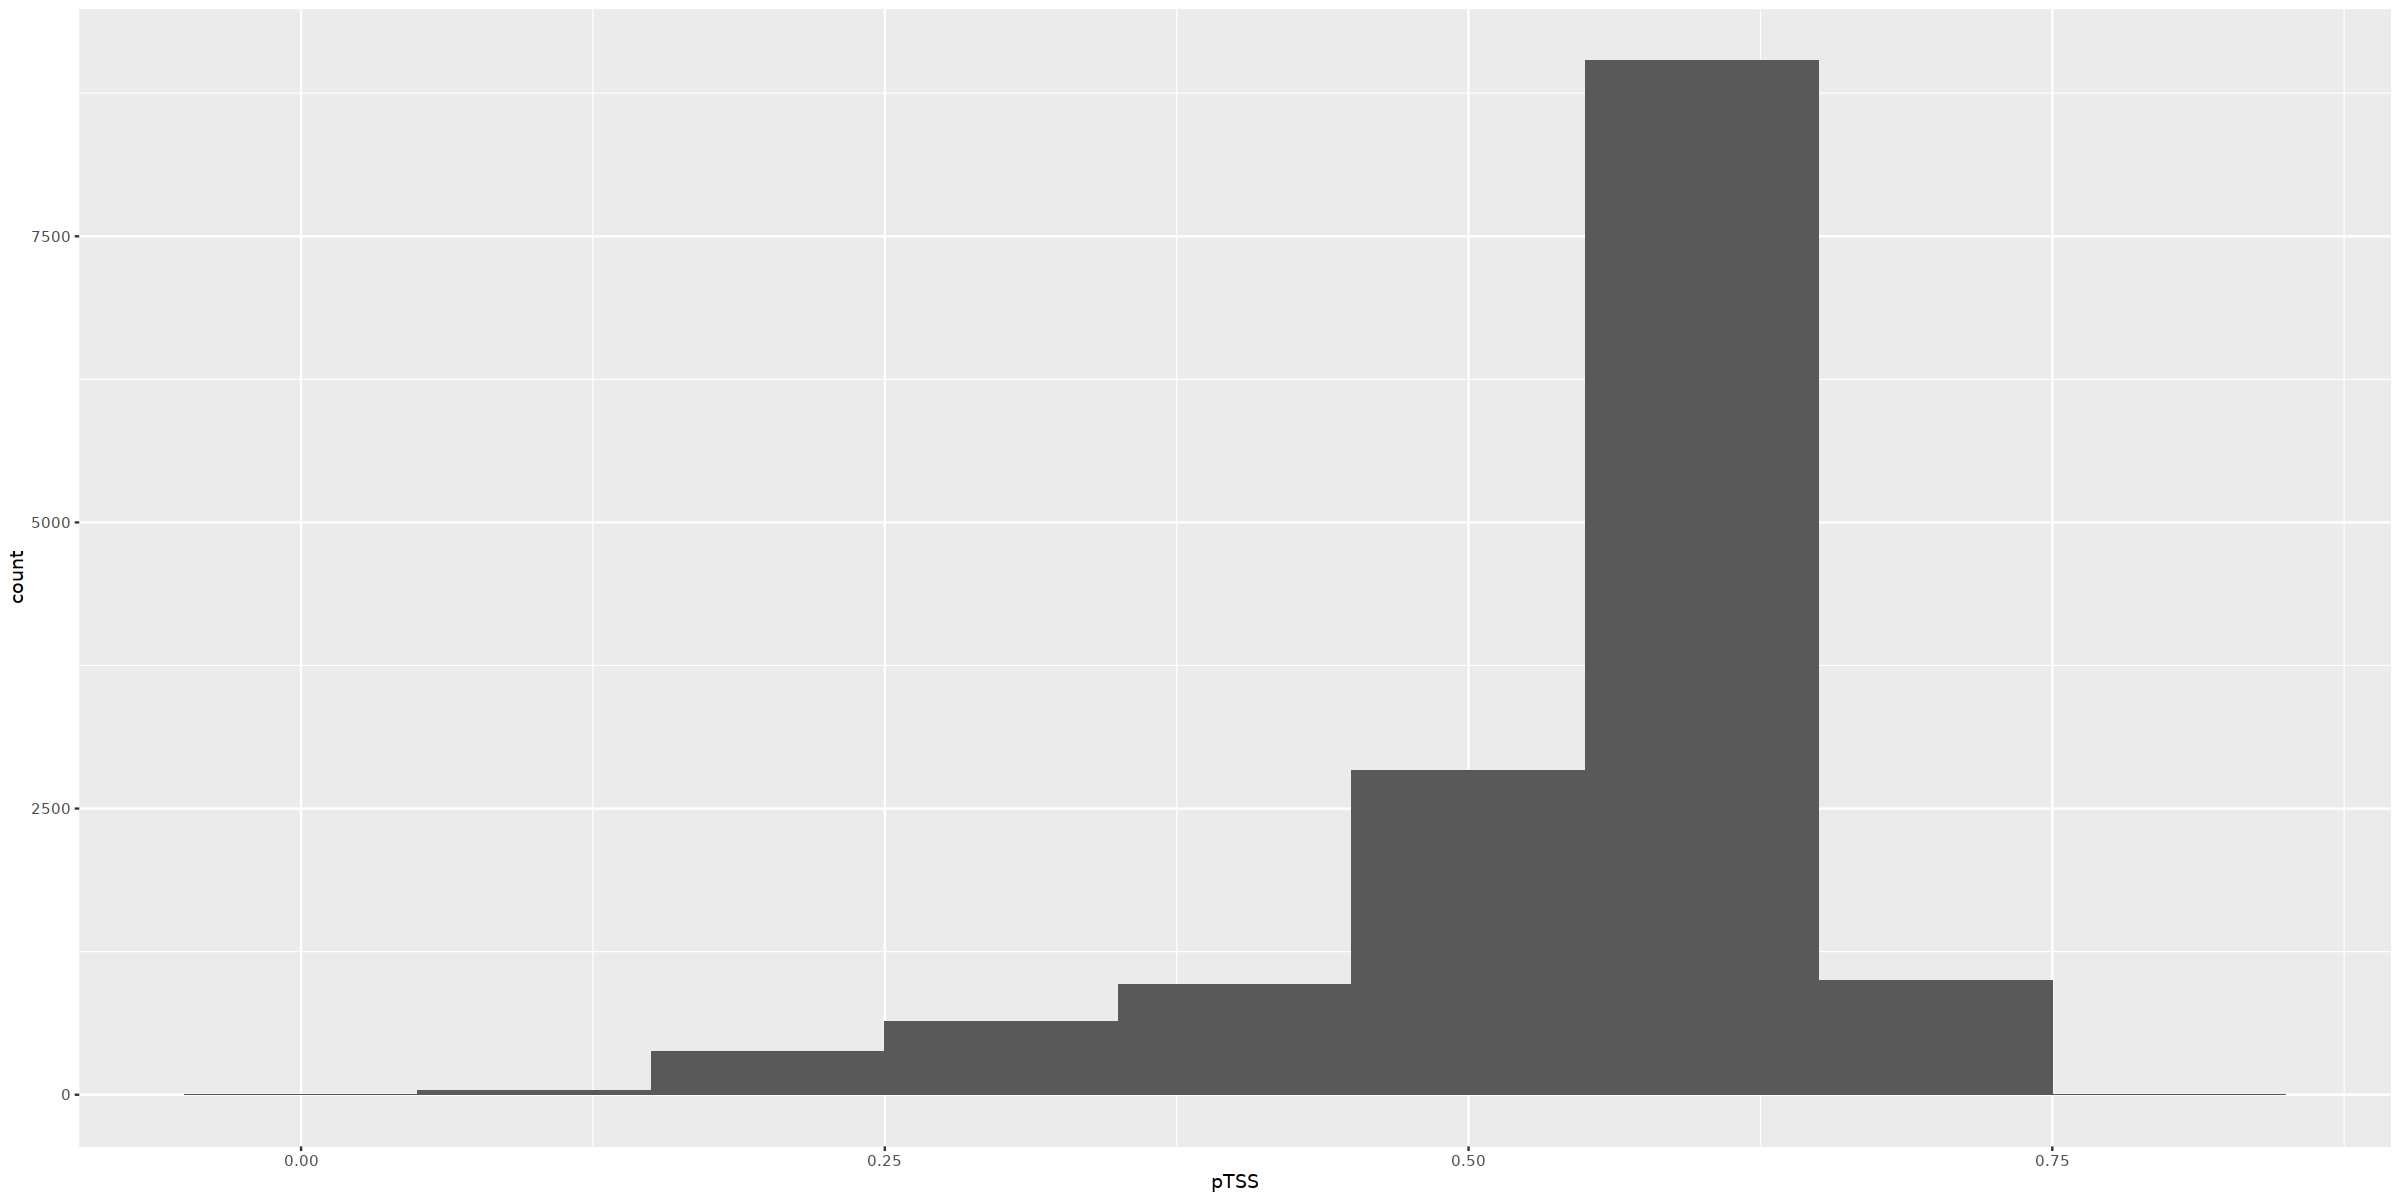

In [79]:
sb_leaf_rep_2.filtered.sparse$meta  %>% 
    dplyr::mutate(prop_ptmt = ptmt/total)  %>% 
    ggplot(., aes(pTSS)) + geom_histogram(binwidth = .1) 
    

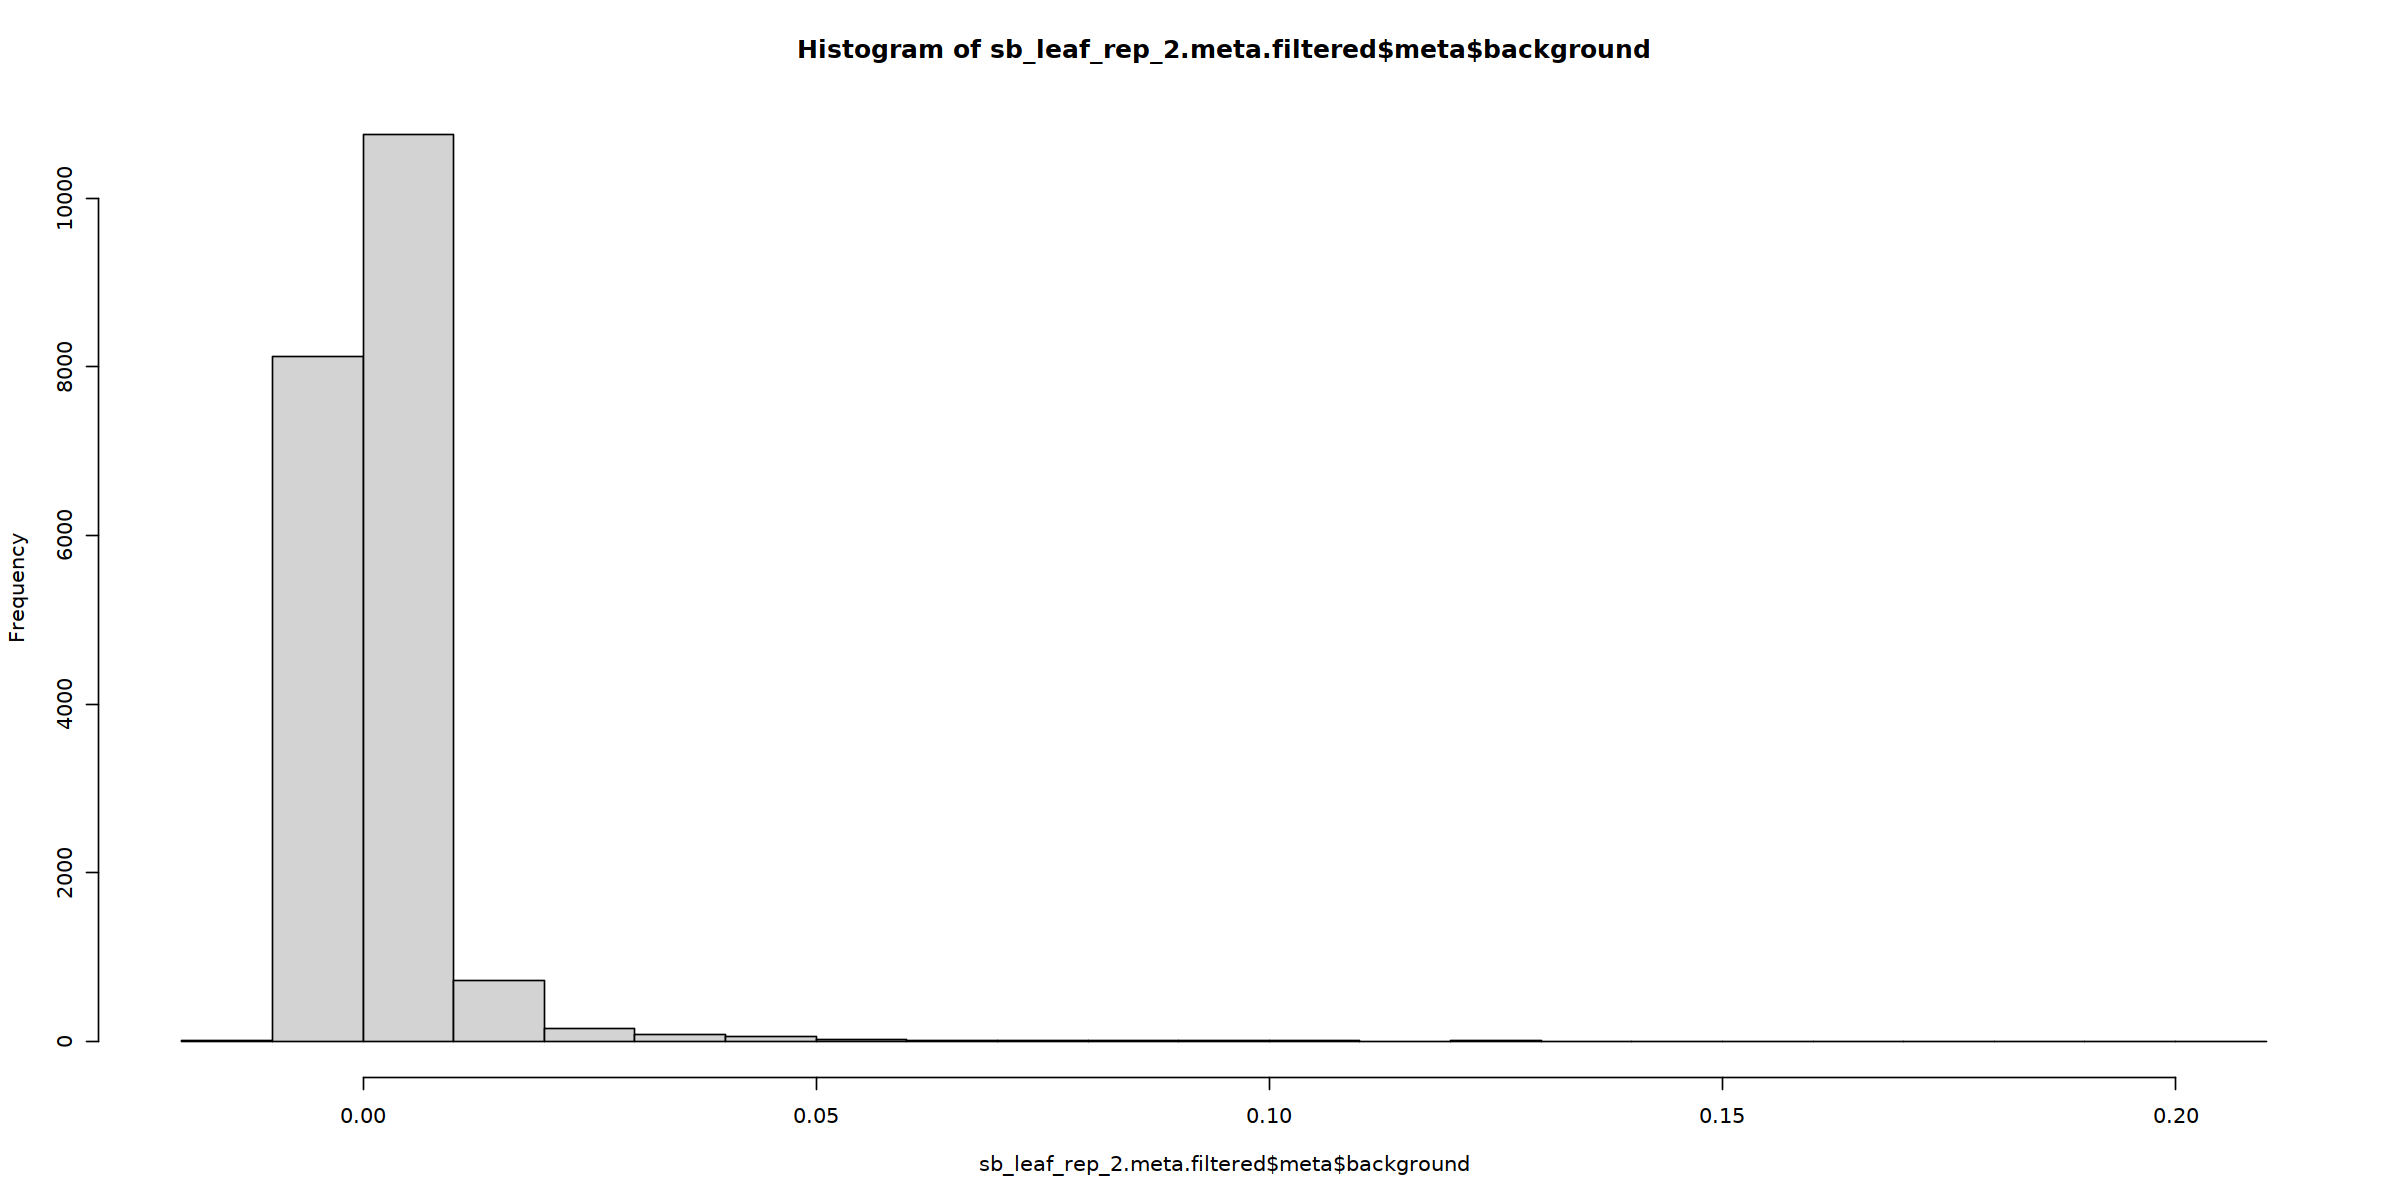

In [75]:
hist(sb_leaf_rep_2.meta.filtered$meta$background)